In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import rqa_functions as rqa
from sklearn.manifold import MDS
from collections import defaultdict
from sklearn.mixture import GaussianMixture
import itertools
from misc_utils import save_to_pickle

In [5]:
def find_indices_to_eliminate(subj1, subj2):
    """
    Calculate the indices to be eliminated based on the differences in trial data points
    for two subjects, ensuring that only the necessary data points are removed to align their sizes.

    Parameters:
    - list_indices_subj1: Numpy array of trial sizes for subject 1
    - list_indices_subj2: Numpy array of trial sizes for subject 2

    Returns:
    - index_to_eliminate_subj1: Indices to eliminate from subject 1 to align with subject 2
    - index_to_eliminate_subj2: Indices to eliminate from subject 2 to align with subject 1
    """

    list_indices_subj1 = np.array([i[1] for i in subj1])
    list_indices_subj2 = np.array([i[1] for i in subj2])

    cumsum_subj1 = [sum([x[1] for x in subj1[:i+1]]) for i in range(len(subj1))]
    cumsum_subj2 = [sum([x[1] for x in subj2[:i+1]]) for i in range(len(subj2))]

    index_differences_sub1 = list_indices_subj1 - list_indices_subj2
    index_differences_sub2 = list_indices_subj2 - list_indices_subj1

    index_to_eliminate_subj1 = []
    for i,n_points in enumerate(index_differences_sub1):
        if n_points>0:
            indexes = [j for j in range(cumsum_subj1[i]-index_differences_sub1[i],cumsum_subj1[i])]
            index_to_eliminate_subj1.extend(indexes)

    index_to_eliminate_subj2 = []
    for i,n_points in enumerate(index_differences_sub2):
        if n_points>0:
            indexes = [j for j in range(cumsum_subj2[i]-index_differences_sub2[i],cumsum_subj2[i])]
            index_to_eliminate_subj2.extend(indexes)

    return index_to_eliminate_subj1[::-1], index_to_eliminate_subj2[::-1]

def session_data_loading(file_path):

    session = (file_path.split('/')[-1]).split('_')[1]
    with open(file_path, 'rb') as file:
        # Load the object from the pickle file
        data = pickle.load(file)

    subj1 = data['subj1']['sizes']
    subj2 = data['subj2']['sizes']

    index_to_eliminate_subj1, index_to_eliminate_subj2 = find_indices_to_eliminate(subj1, subj2)

    file_order_size = []
    for i in range(len(subj1)):
        file_sub1,len_1 = subj1[i]
        file_sub2,len_2 = subj2[i]
        if len_1 < len_2:
            file_order_size.append((file_sub1,file_sub2,len_1))
        else:
            file_order_size.append((file_sub1,file_sub2,len_2))

    mat1 = data['subj1']['distances']
    for index in index_to_eliminate_subj1:
        mat1 = np.delete(np.delete(mat1, index, axis=0), index, axis=1)

    mat2 = data['subj2']['distances']
    for index in index_to_eliminate_subj2:
        mat2 = np.delete(np.delete(mat2, index, axis=0), index, axis=1)

    trial_len = [i[2] for i in file_order_size]
    start_points = list(np.cumsum(trial_len))
    end_points = [i-1 for i in start_points]
    start_points.insert(0,0)
    start_points.pop(-1)
    #print(start_points)
    #print(end_points)
    start_stop = list(zip(start_points,end_points))
    #print(start_stop)

    condition_dictionary = {1: 'Uncoupled', 2: '1_lead', 3: '2_lead', 4: 'Mutual'}
    type_dictionary = {1: 'Synchronization', 2: 'Syncopation'}

    # Initialize an empty list to store each row's data as a dictionary
    data = []

    for i, entry in enumerate(file_order_size):
        session = entry[0].split('/')[0]
        trial = entry[0].split('_')[2][:-4]
        length = entry[2]
        start, stop = start_stop[i]
        filename = '/data/Italo/finger_tapping_behavioral_data/clean_' + str(session) + '_bpchan.mat'
        beh_data = loadmat(filename)
        conditions = list(beh_data['conditions'][0])
        condition = condition_dictionary[conditions[int(trial)-1]]
        session_type = type_dictionary[beh_data['session'][0][0]]

        # Instead of printing, store the data in a dictionary
        row_data = {
            'session': session,
            'session_type': session_type,
            'condition': condition,
            'trial': trial,
            'start': start,
            'stop': stop
        }

        # Append the dictionary to the list
        data.append(row_data)

    # Convert the list of dictionaries to a pandas DataFrame
    metadata = pd.DataFrame(data)
    session_data = {'Subject 1': mat1,
                    'Subject 2': mat2,
                    'Metadata': metadata,
                    'Session Type': session_type}
    return session, session_data

In [2]:
# Specify the directory where the files are located
directory_path = "/data/Italo/correlation_distances"

# List all files and directories in the specified path
all_items = os.listdir(directory_path)

# Filter out files that start with "dyad_20"
matching_files = [filename for filename in all_items if filename.startswith("dyad_20")]

# Optionally, get the full paths if needed
full_paths = [os.path.join(directory_path, filename) for filename in matching_files]

# Print the list of matching file paths
for file_path in full_paths:
    print(file_path)

/data/Italo/correlation_distances/dyad_20221003_distances.pkl
/data/Italo/correlation_distances/dyad_20220713_distances.pkl
/data/Italo/correlation_distances/dyad_20220816_distances.pkl
/data/Italo/correlation_distances/dyad_20221005_distances.pkl
/data/Italo/correlation_distances/dyad_2022100401_distances.pkl
/data/Italo/correlation_distances/dyad_20220810_distances.pkl
/data/Italo/correlation_distances/dyad_2022100402_distances.pkl
/data/Italo/correlation_distances/dyad_20220811_distances.pkl
/data/Italo/correlation_distances/dyad_20220721_distances.pkl
/data/Italo/correlation_distances/dyad_20220808_distances.pkl
/data/Italo/correlation_distances/dyad_20220815_distances.pkl
/data/Italo/correlation_distances/dyad_20220804_distances.pkl


In [6]:
# Loads the correlation matrices in a single dictionary.

session_data = {}
for file_path in full_paths:
    session,data = session_data_loading(file_path)
    session_data[session] = data

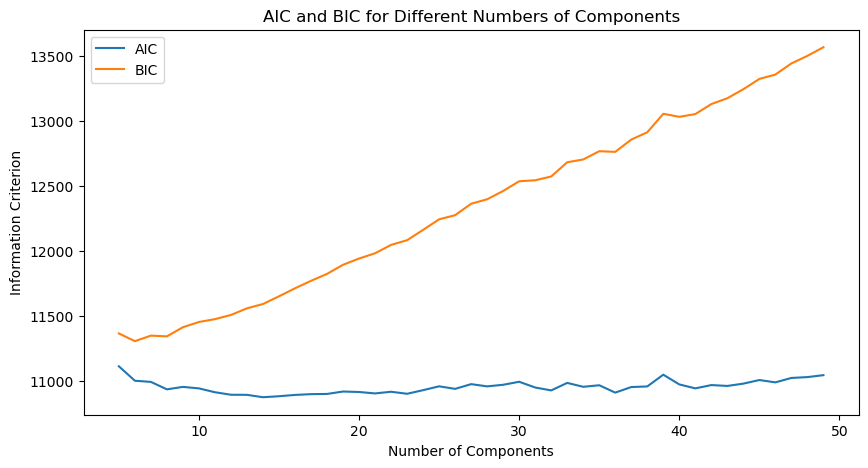

Optimal number of components according to AIC: 14
Optimal number of components according to BIC: 6


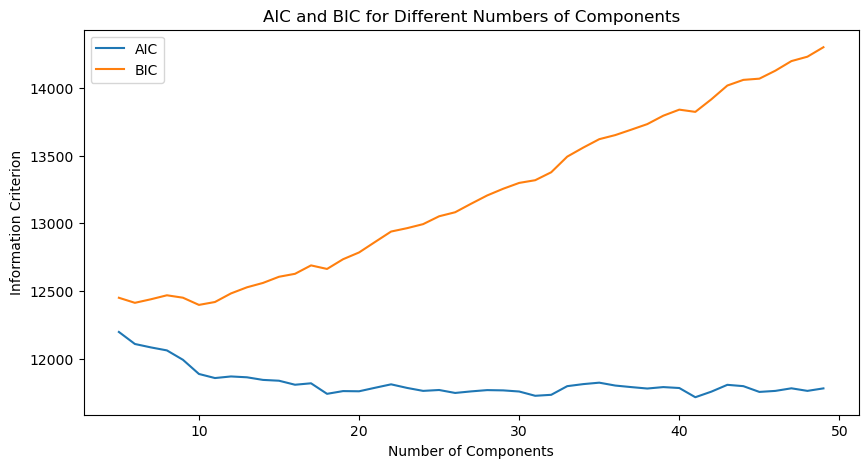

Optimal number of components according to AIC: 41
Optimal number of components according to BIC: 10


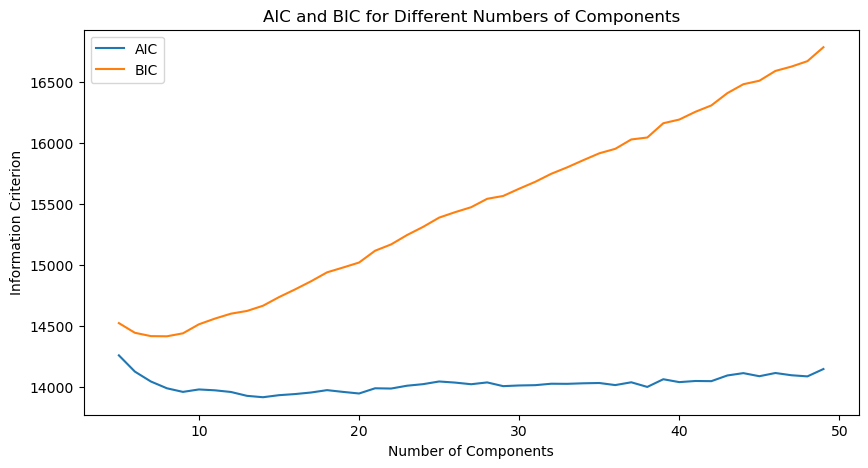

Optimal number of components according to AIC: 14
Optimal number of components according to BIC: 8


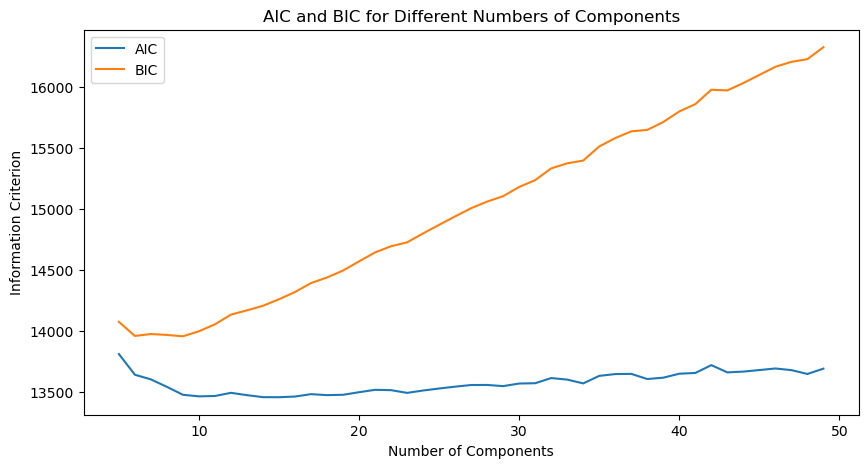

Optimal number of components according to AIC: 15
Optimal number of components according to BIC: 9


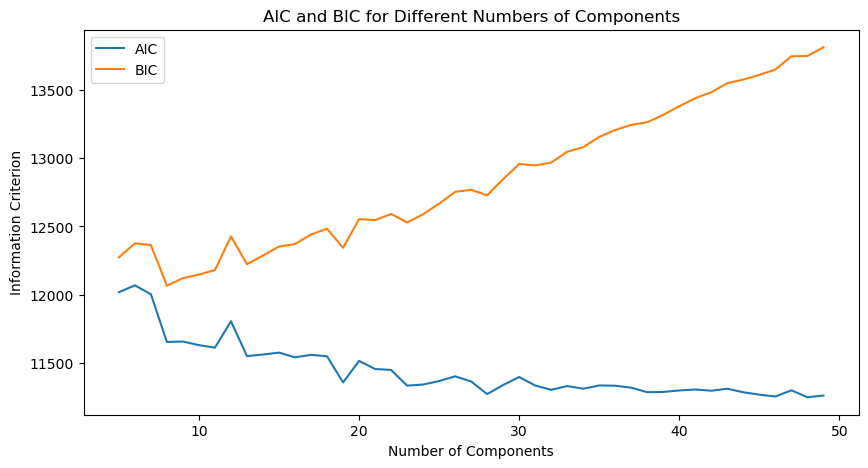

Optimal number of components according to AIC: 48
Optimal number of components according to BIC: 8


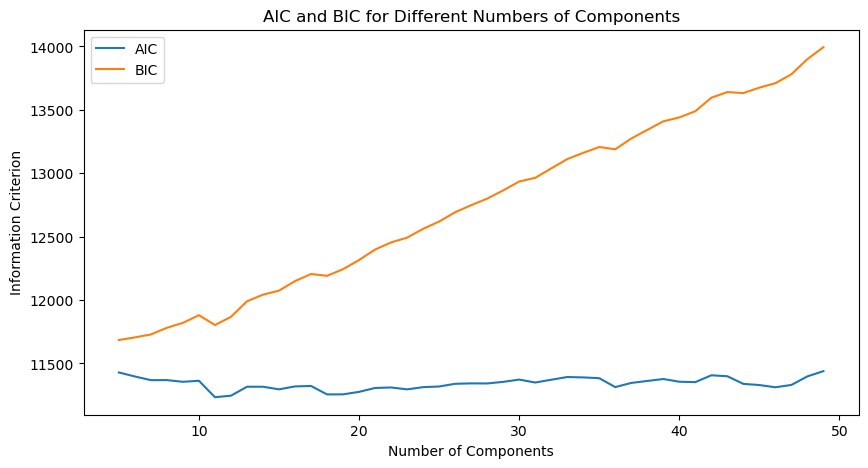

Optimal number of components according to AIC: 11
Optimal number of components according to BIC: 5


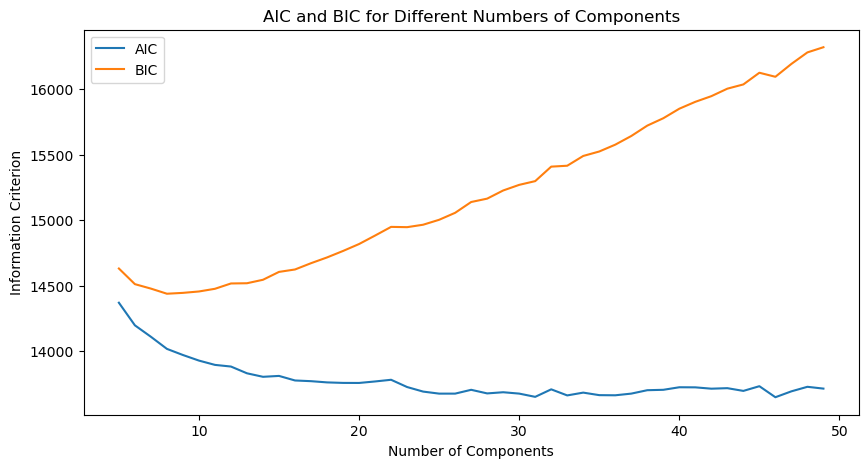

Optimal number of components according to AIC: 46
Optimal number of components according to BIC: 8


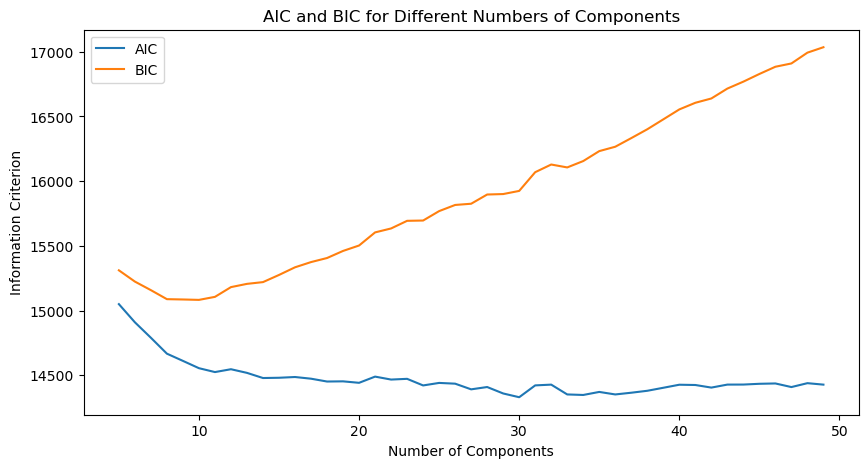

Optimal number of components according to AIC: 30
Optimal number of components according to BIC: 10


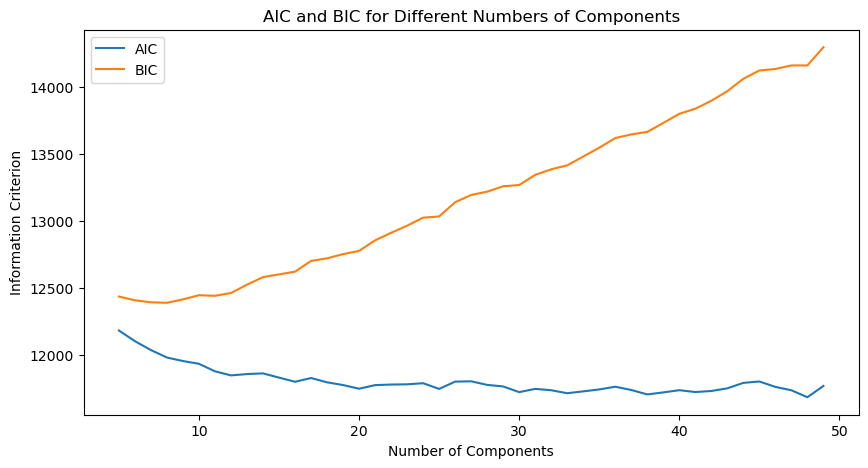

Optimal number of components according to AIC: 48
Optimal number of components according to BIC: 8


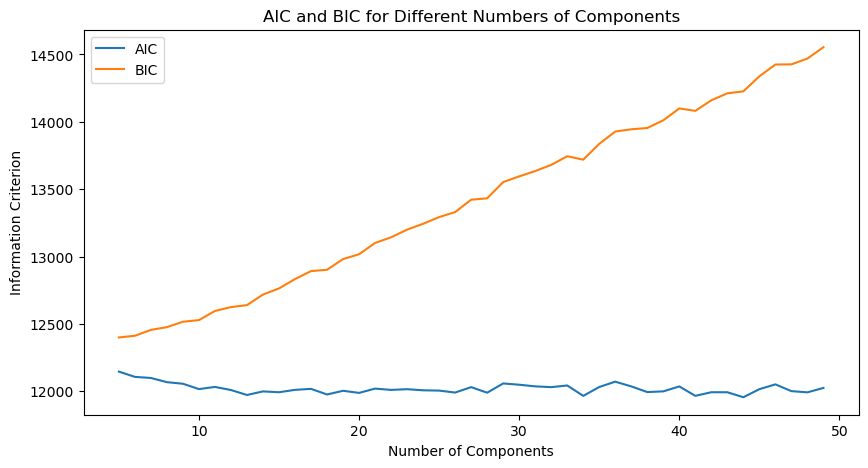

Optimal number of components according to AIC: 44
Optimal number of components according to BIC: 5


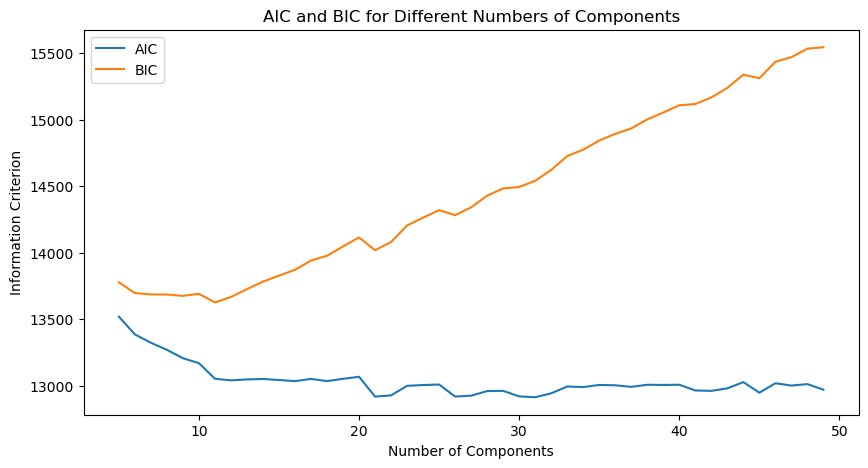

Optimal number of components according to AIC: 31
Optimal number of components according to BIC: 11


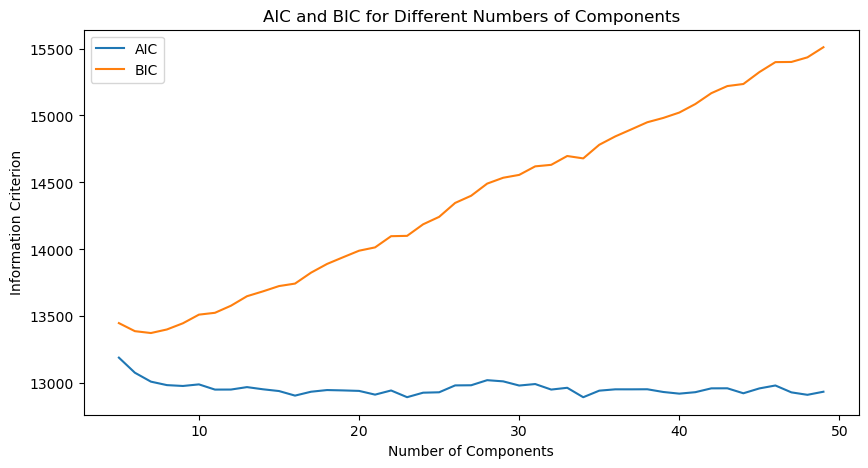

Optimal number of components according to AIC: 34
Optimal number of components according to BIC: 7


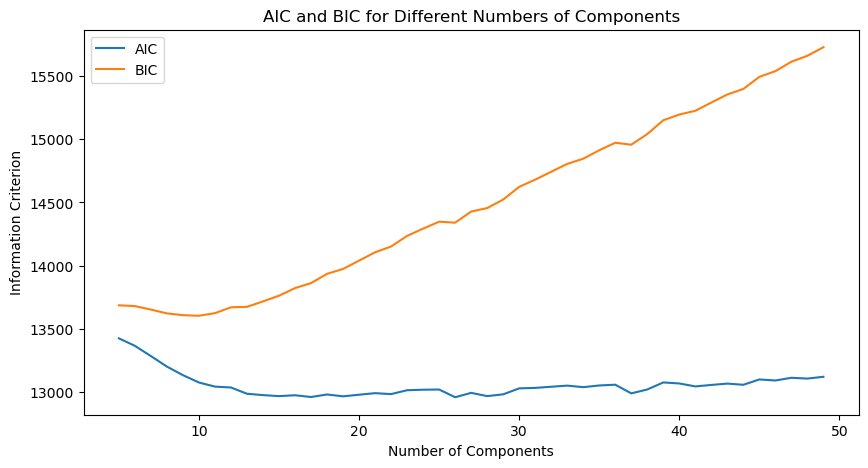

Optimal number of components according to AIC: 26
Optimal number of components according to BIC: 10


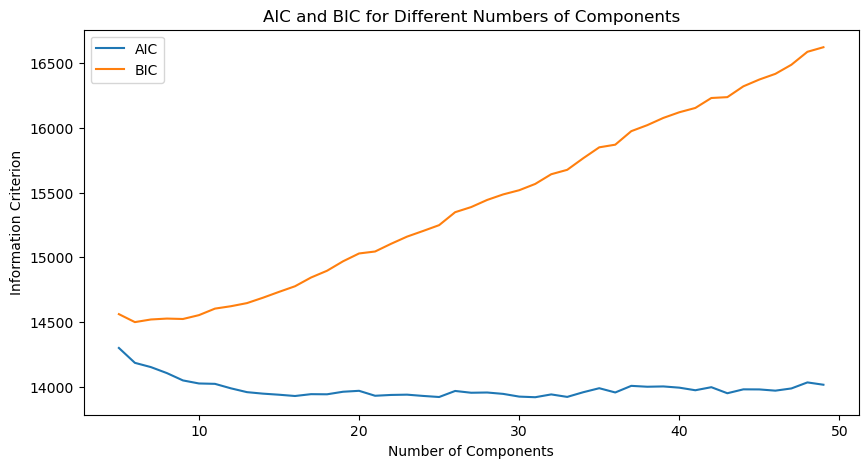

Optimal number of components according to AIC: 31
Optimal number of components according to BIC: 6


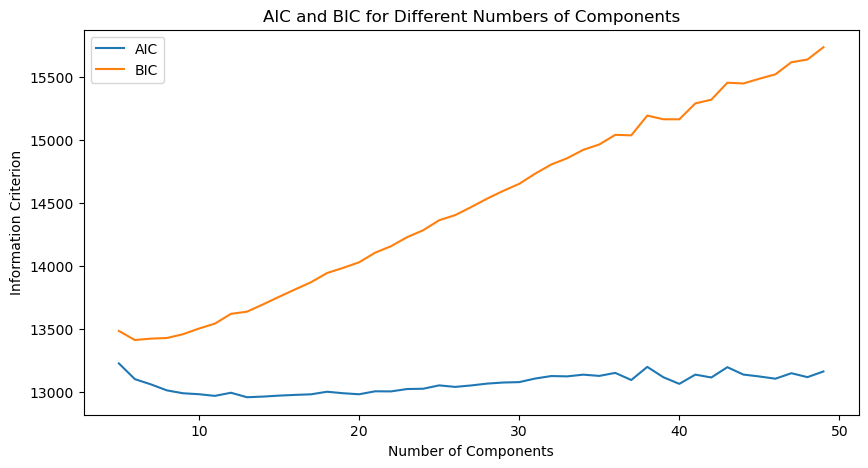

Optimal number of components according to AIC: 13
Optimal number of components according to BIC: 6


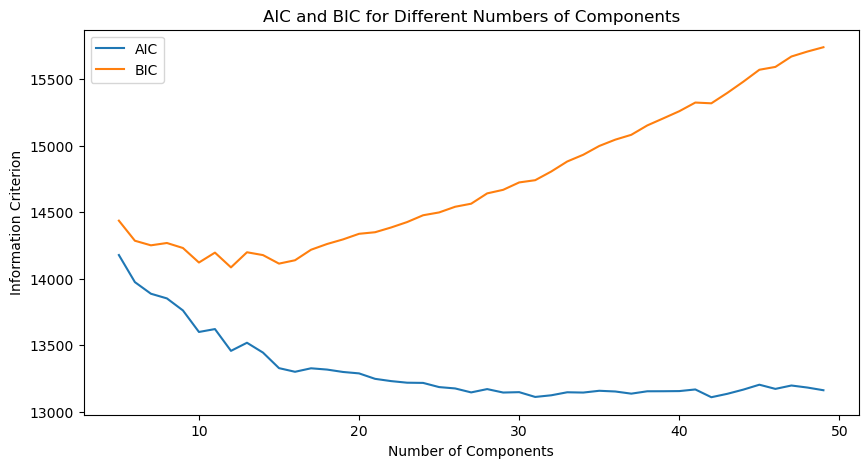

Optimal number of components according to AIC: 42
Optimal number of components according to BIC: 12


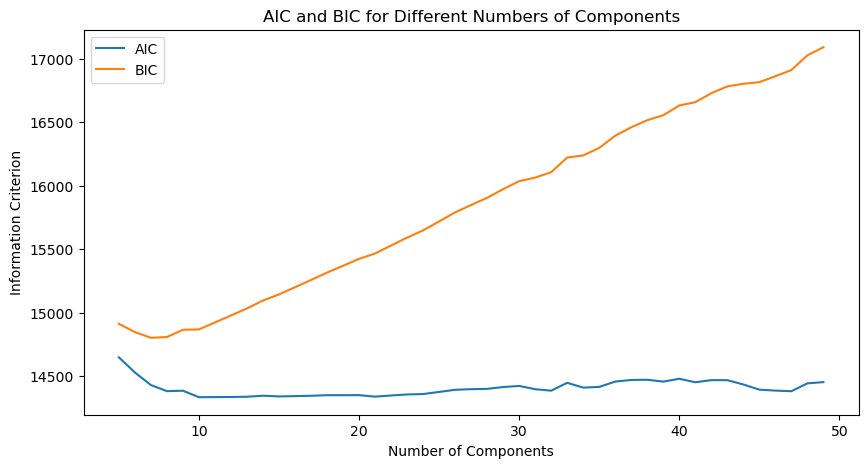

Optimal number of components according to AIC: 10
Optimal number of components according to BIC: 7


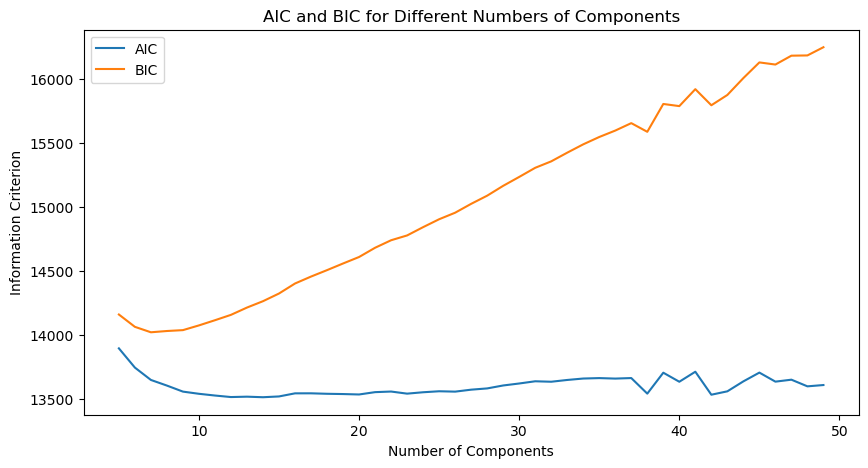

Optimal number of components according to AIC: 14
Optimal number of components according to BIC: 7


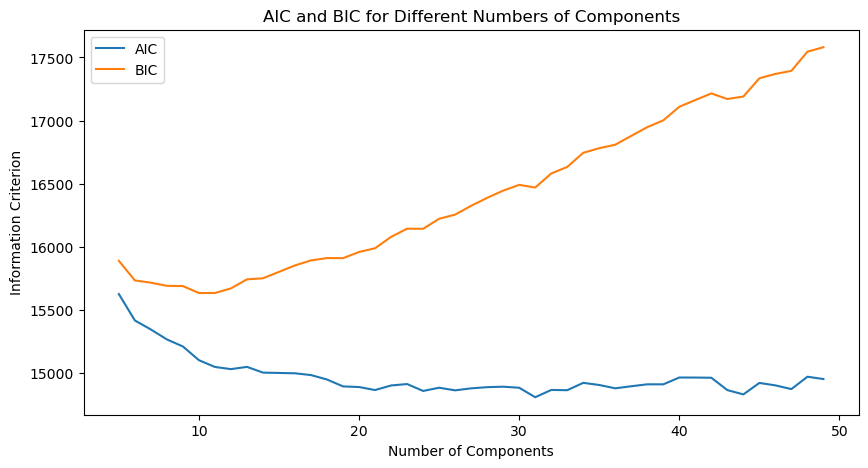

Optimal number of components according to AIC: 31
Optimal number of components according to BIC: 10


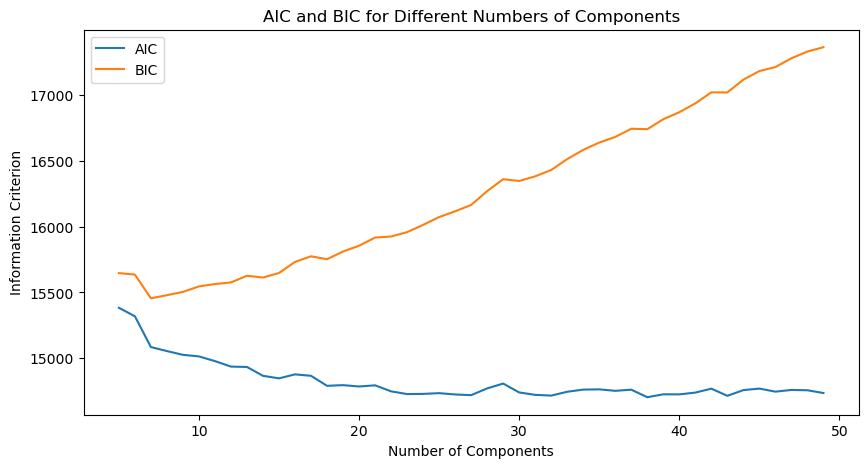

Optimal number of components according to AIC: 38
Optimal number of components according to BIC: 7


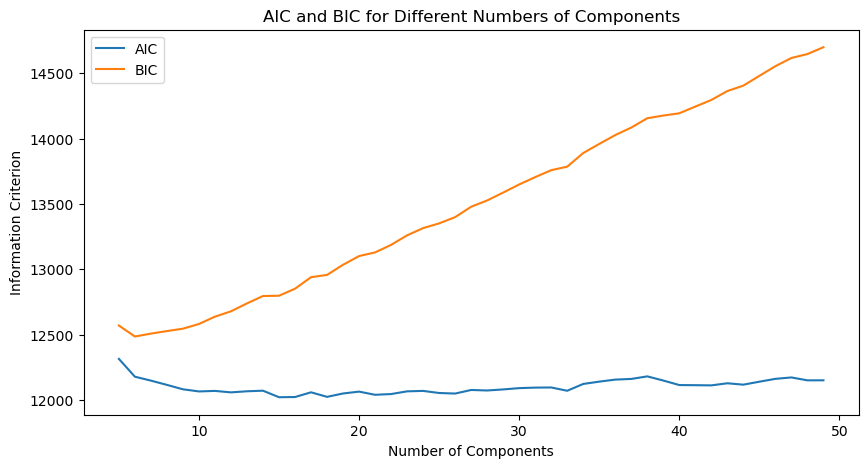

Optimal number of components according to AIC: 15
Optimal number of components according to BIC: 6


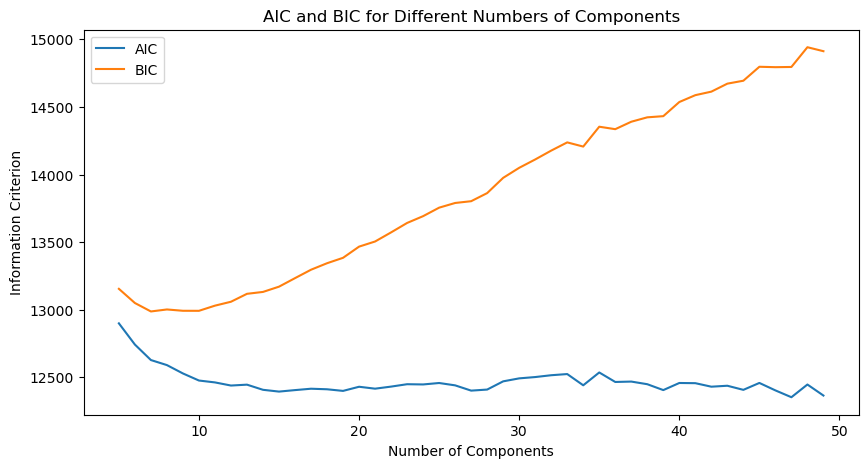

Optimal number of components according to AIC: 47
Optimal number of components according to BIC: 7


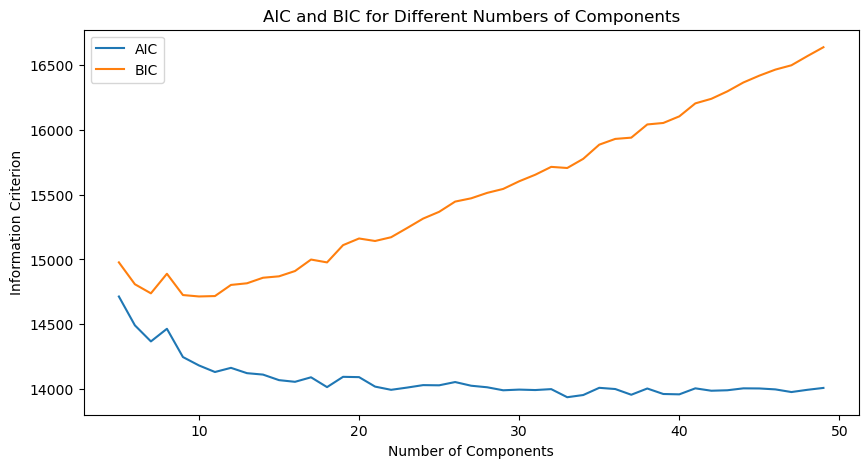

Optimal number of components according to AIC: 33
Optimal number of components according to BIC: 10


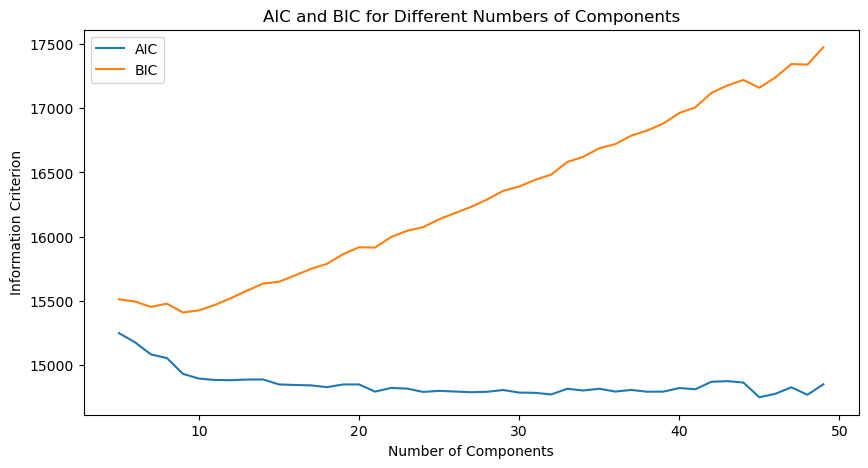

Optimal number of components according to AIC: 45
Optimal number of components according to BIC: 9


In [7]:
# Plot to check the minima of BIC for each session.

for session_code in session_data:
    mat1,mat2,_,_ =  session_data[session_code].values()
    for matrix in [mat1,mat2]:
        # Assuming you have a precomputed distance matrix 'distance_matrix'
        mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
        low_dim_embeddings = mds.fit_transform(matrix)

        n_components_range = range(5, 50)  # Adjust based on your dataset and needs
        aic_values = []
        bic_values = []

        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components, random_state=0).fit(low_dim_embeddings)
            aic_values.append(gmm.aic(low_dim_embeddings))
            bic_values.append(gmm.bic(low_dim_embeddings))

        #aic_values = smooth_data_with_neighbors(aic_values, 2)
        #bic_values = smooth_data_with_neighbors(bic_values, 2)

        plt.figure(figsize=(10, 5))
        plt.plot(n_components_range, aic_values, label='AIC')
        plt.plot(n_components_range, bic_values, label='BIC')
        plt.xlabel('Number of Components')
        plt.ylabel('Information Criterion')
        plt.legend()
        plt.title('AIC and BIC for Different Numbers of Components')
        plt.show()

        optimal_n_aic = n_components_range[np.argmin(aic_values)]
        optimal_n_bic = n_components_range[np.argmin(bic_values)]

        print(f"Optimal number of components according to AIC: {optimal_n_aic}")
        print(f"Optimal number of components according to BIC: {optimal_n_bic}")


In [8]:
# Define each subject symbolic sequence for each session and stores in a dictionary

session_clusterings = {}
for session_code in session_data:
    mat1,mat2,_,_ =  session_data[session_code].values()
    clusterings = []
    for matrix in [mat1,mat2]:
        # Assuming you have a precomputed distance matrix 'distance_matrix'
        mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
        low_dim_embeddings = mds.fit_transform(matrix)

        n_components_range = range(5, 50)  # Adjust based on your dataset and needs
        aic_values = []
        bic_values = []

        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components, random_state=0).fit(low_dim_embeddings)
            aic_values.append(gmm.aic(low_dim_embeddings))
            bic_values.append(gmm.bic(low_dim_embeddings))

        optimal_n_bic = n_components_range[np.argmin(bic_values)]
        gmm = GaussianMixture(n_components=optimal_n_bic, random_state=0).fit(low_dim_embeddings)
        cluster_sequence = gmm.predict(low_dim_embeddings)
        clusterings.append(cluster_sequence)
    session_clusterings[session_code] = clusterings

In [ ]:
# Saves the symbolic sequences in a pickle file.

# save_to_pickle(session_clusterings, './clustering_data.pkl')